# TAIL CAMP AI实战训练营 NLP 第一周项目报告——句子语义相似度预测

## Contents


1. 项目简介
2. 思路与实现
3. 结果与讨论
4. 回顾与总结


## 1. 项目简介

本次的项目目标是"预测教师培训或类似场景中内容主题的相似性, 提高教学效率".

实战训练阶段, 我们在一个简化的场景下进行学习: 给定一系列的英文句子对, 每个句子对中的两个句子, 在语义上具有一定的相似性, 用 0 到 5 之间的分值来衡量两个句子的语义相似性. 语义相似性越高, 得分越高.

示例如下:

In [1]:
import pandas as pd

df_train = pd.read_csv("train_ai-lab.txt", delimiter="\t", header=None, names=["id", "sent1", "sent2", "similarity"])
df_test = pd.read_csv("test_ai-lab.txt", delimiter="\t", header=None, names=["id", "sent1", "sent2", "simiarlity"])

df_train.head(3)

,id,sent1,sent2,similarity
0,10001,two big brown dogs running through the snow.,A brown dog running through the grass.,2.000
1,10002,A woman is peeling a potato.,A woman is slicing a tomato.,1.333
2,10003,A small boy is building with some wooden blocks.,A small boy wearing a blue shirt stacks wooden...,4.000


可以出, 对两个句子的相似性进行评分是一项很主观的任务. 主观性带来的结果是很难有一个统一的评价指标, 这使得任务更加艰巨.

用机器学习的方法取代或辅助人类对相似性评分, 能极大地弥补人工评分的不足, 同时提高效率.

上述 `df_train` 就是项目的训练数据, `df_test`则是测试数据. 训练的目标是通过对训练数据的学习, 使得机器习得人类对句子语义相似性的评估.

## 2. 思路与实现

### 2.1 数据分析

在我们看来, 本项目属于 Text Mining 的范畴. 磨刀不误砍柴工, 首先对数据进行分析.

> 助教已经提供了一份较为完善的 Text Analysis, 为保证报告完整性, 我们选择了加上 Text Analysis 这一部分.

首先, 我们对训练数据与测试数据的基本信息进行对比, 简单地考虑以下两方面:

* 句子长度;
* 句子包含的单词数 (包括停词)

###### 训练集 vs. 测试集 - 句子长度

可以看到, 训练数据与测试数据在`句子长度`这一特征上, 概率分布基本吻合.

由于数据量较小, 直方图显得不那么平滑, 某些长度的句子在训练集和测试集中出现的概率有明显差异.

均值-训练 37.40
标准差-训练 14.16
最大值-训练 147.00
均值-测试37.60
标准差-测试 14.46
最大值-测试 113.00


/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


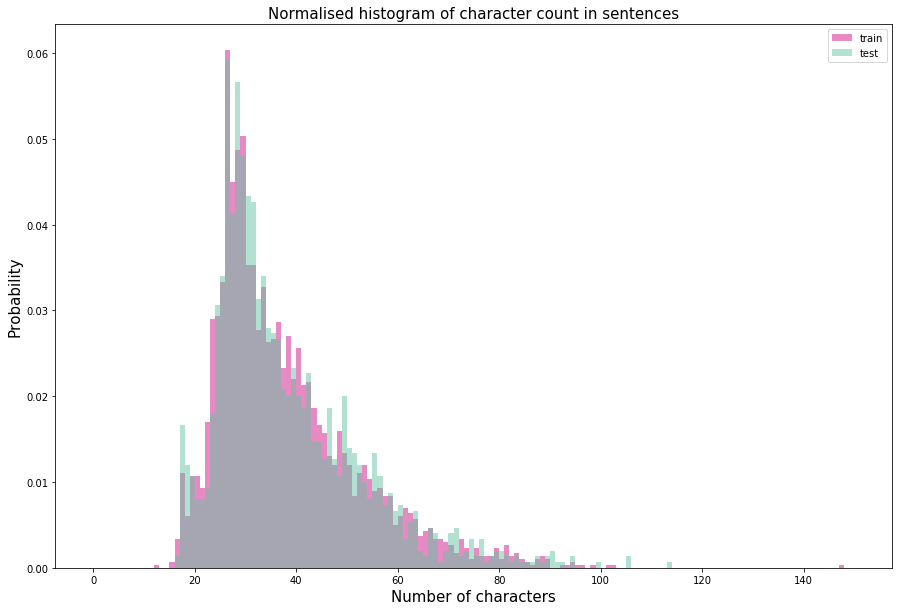

In [100]:
train_sents = pd.Series(df_train['sent1'].tolist() + df_train['sent2'].tolist()).astype(str)
test_sents = pd.Series(df_test['sent1'].tolist() + df_test['sent2'].tolist()).astype(str)

dist_train = train_sents.apply(len)
dist_test = test_sents.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=150, range=[0, 150], color=pal[3], normed=True, label='train')
plt.hist(dist_test, bins=150, range=[0, 150], color=pal[8], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('均值-训练 {:.2f}\n标准差-训练 {:.2f}\n最大值-训练 {:.2f}\n均值-测试{:.2f}\n标准差-测试 {:.2f}\n最大值-测试 {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max(), dist_test.mean(), dist_test.std(), dist_test.max()))

###### 训练集 vs. 测试集 - 单词数

从下图可以看到, 训练数据与测试数据在`单词数`这一特征上, 概率分布也基本吻合, 且分布的形状与`句子长度`相似.

均值-训练 7.74
标准差-训练 2.80
最大值-训练 26.00
均值-测试 7.82
标准差-测试 2.90
最大值-测试 24.00


/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


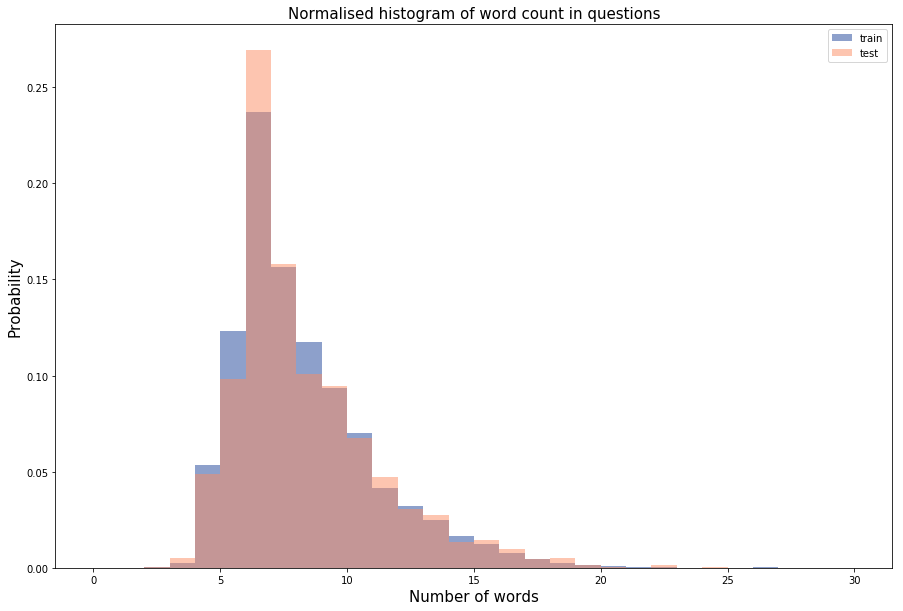

In [53]:
dist_train = train_sents.apply(lambda x: len(x.split(' ')))
dist_test = test_sents.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=30, range=[0, 30], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=30, range=[0, 30], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('均值-训练 {:.2f}\n标准差-训练 {:.2f}\n最大值-训练 {:.2f}\n均值-测试 {:.2f}\n标准差-测试 {:.2f}\n最大值-测试 {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max(), dist_test.mean(), dist_test.std(), dist_test.max()))

接下来我们对训练集中句子的语义相似性进行分析.

从下图的`相似度`分布中可以看出, 除了两个句子完全不具有相似性 (0 分) 的情况特别多之外, 句子的语义相似性在完全不相似与完全相同之间总体表现为均匀分布.

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


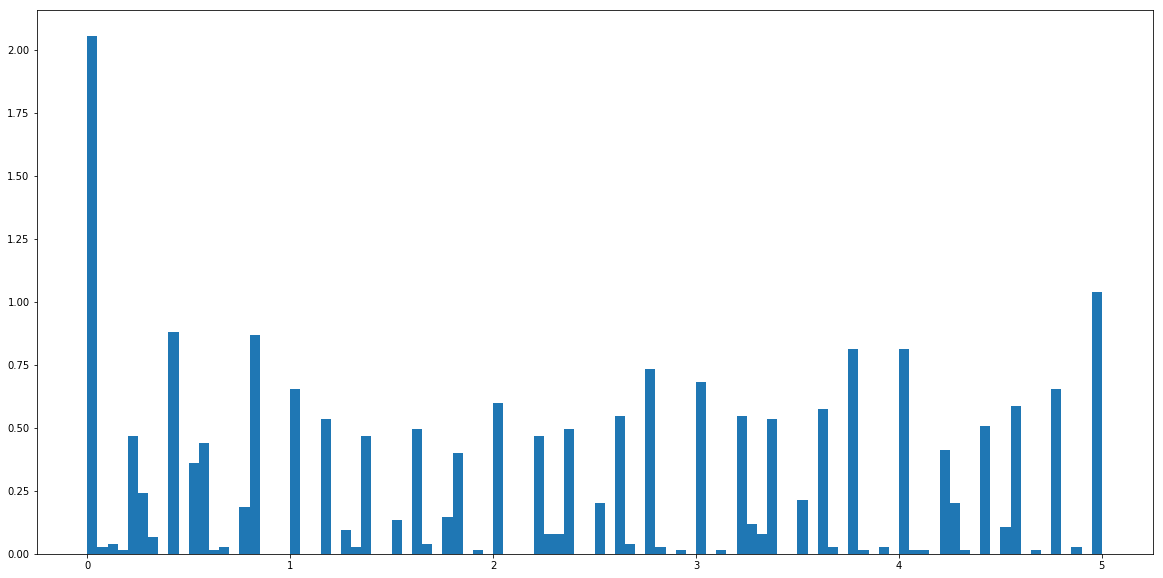

In [98]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pal = sns.color_palette("Set2", 10)

plt.figure(figsize=(20,10)) 
# sim_freq = np.array(sorted([(s, f) for s, f in zip(df_train.similarity.value_counts().index, df_train.similarity.value_counts())], key=lambda t: t[0]))
plt.hist(df_train.similarity, bins=100, normed=True)
plt.show()

我们简单的数据分析到这里就结束了.

经过对训练数据与测试数据中的`句子长度`和`单词数`的对比, 我们基本可以确定, 训练数据与测试数据是独立同分步的.

因此, 我们可以有一个先验的印象: ***测试数据的相似性从完全不相似到完全相同之间大致也表现为均匀分布, 并且完全不相似的情况会更多.*** 

这给了我们两点启示:

* 在训练阶段, 可以首先对相似度为 0 的样本进行降采样;
* 在预测阶段, 可以将*预测值总体是否服从均匀分布*作为衡量预测结果的一项指标.

### 2.2 28 个特征 + XGBRegressor 的第一次尝试

Kaggle 上有一个[Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/overview)的竞赛, 其目标是判断两个提问是否重复了. 这和我们的任务具有一定的相似性.

因此, 我们首先在 Kaggle 的讨论区浏览了一些解决方案. 借鉴[本文](https://www.linkedin.com/pulse/duplicate-quora-question-abhishek-thakur/), 我们首先提取了 28 个特征, 包括:

* 字面特征 f1s:
    * 句子1 的长度
    * 句子2 的长度
    * 句子间的长度差
    * 句子1 的非空格字符数
    * 句子2 的非空格字符数
    * 句子1 的单词数
    * 句子2 的单词数
    * 句子间的共同单词比
* 模糊特征 f2s:
    * Q Ratio
    * W Ratio
    * Partial ratio
    * Partial token set ratio
    * Partial token sort ratio
    * Token set ratio
    * Token sort ratio
* 词向量相关的距离特征 f3s:
    * Word mover distance (第一次实验未包含)
    * Normalized word mover distance (第一次实验未包含)
    * 句子向量 (sentence vectors) 间的 Cosine 距离
    * 句子向量间的 Manhattan 距离
    * 句子向量间的 Jaccard 距离
    * 句子向量间的 Canberra 距离
    * 句子向量间的 Euclidean 距离
    * 句子向量间的 Minkowski 距离
    * 句子向量间的 Braycurtis 距离
    * 句子1 向量的 Skew 统计量
    * 句子2 向量的 Skew 统计量
    * 句子1 向量的 Kurtosis 统计量
    * 句子2 向量的 Kurtosis 统计量

一开始我们只使用了 XGBRegressor (`learning_rate=0.02`, `max_depth=4`), 在使用 [Glove.6B.100d.txt](http://nlp.stanford.edu/data/wordvecs/glove.6B.zip) 的情况下, 在平台上的得分达到了 0.773975! 这在现在看来也是一个中等偏好的成绩. **结果与讨论**放在本文的第三部分, 在此先按下不表.

在项目训练阶段, 我们并没有考虑特征的有效性, 而是一股脑儿地全部"喂"给了模型.

在此, 我们对个别特征的有效性做一个简单的调研, 主要包括:

* 句子间共用单词数
* Q Ratio
* 句子向量间的 Cosine 距离

###### 句子间共用单词比

我们首先调查了`共用单词比`与句子语义相似性的关系.

> 因为 similarity 的分布总体呈现为均匀分布, 我们就简单地以 2.5 为界, 将句子对分类为*相似*与*不相似*两类来考量特征的有效性.

我们发现, 就这一维度而言, 语义相似性的分布有较明显的差异, 表明这是一个相对有力的特征. 并且, 去掉停词之后, 这种差异更加明显.

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


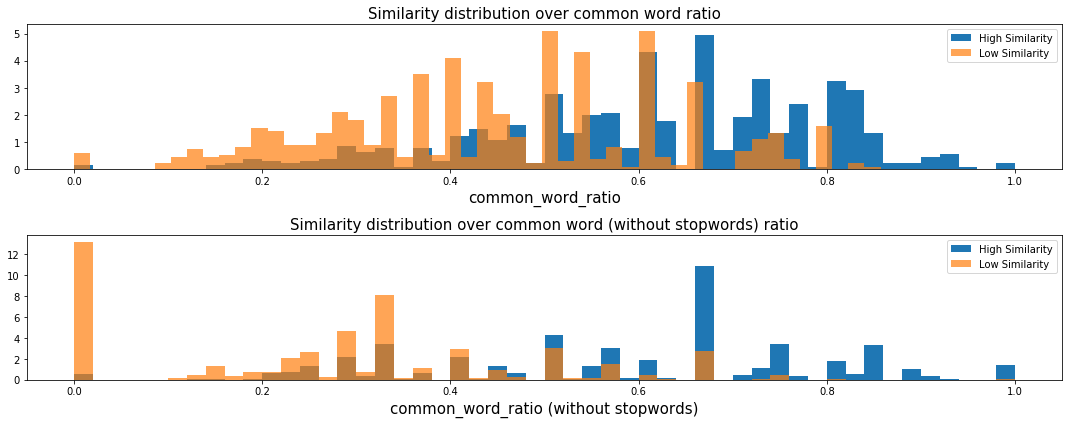

In [101]:
from functools import partial
from nltk.corpus import stopwords
from keras.preprocessing.text import text_to_word_sequence

stopwords_eng = stopwords.words("english")
                                
def common_word_ratio(row, no_stopwords=False):
    if no_stopwords:
        words1 = set([w for w in text_to_word_sequence(row["sent1"]) if w not in stopwords_eng])
        words2 = set([w for w in text_to_word_sequence(row["sent2"]) if w not in stopwords_eng])
    else:
        words1 = set(text_to_word_sequence(row["sent1"]))
        words2 = set(text_to_word_sequence(row["sent2"]))
    
    common_words = words1.intersection(words2)
    R = (len(common_words) * 2)/(len(words1) + len(words2))
    return R

cwr_no_stopwords = partial(common_word_ratio, no_stopwords=True)

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
train_cwr = df_train.apply(common_word_ratio, axis=1, raw=True)
plt.hist(train_cwr[df_train['similarity'] > 2.5], bins=50, normed=True, label='High Similarity')
plt.hist(train_cwr[df_train['similarity'] < 2.5], bins=50, normed=True, alpha=0.7, label='Low Similarity')
plt.legend()
plt.title('Similarity distribution over common word ratio', fontsize=15)
plt.xlabel('common_word_ratio', fontsize=15)


plt.subplot(2, 1, 2)
train_cwr_no_stopwords = df_train.apply(cwr_no_stopwords, axis=1, raw=True)
plt.hist(train_cwr_no_stopwords[df_train['similarity'] > 2.5], bins=50, normed=True, label='High Similarity')
plt.hist(train_cwr_no_stopwords[df_train['similarity'] < 2.5], bins=50, normed=True, alpha=0.7, label='Low Similarity')
plt.legend()
plt.title('Similarity distribution over common word (without stopwords) ratio', fontsize=15)
plt.xlabel('common_word_ratio (without stopwords)', fontsize=15)
plt.tight_layout()

###### 句子间的 Q Ratio

同`共用单词比`一样, 语义相似性在 Q Ratio 上分布的差异较为明显, 且去掉停词之后, 差异表现得更为明显. 这表明 Q Ratio 同样是一个可用的特征.

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


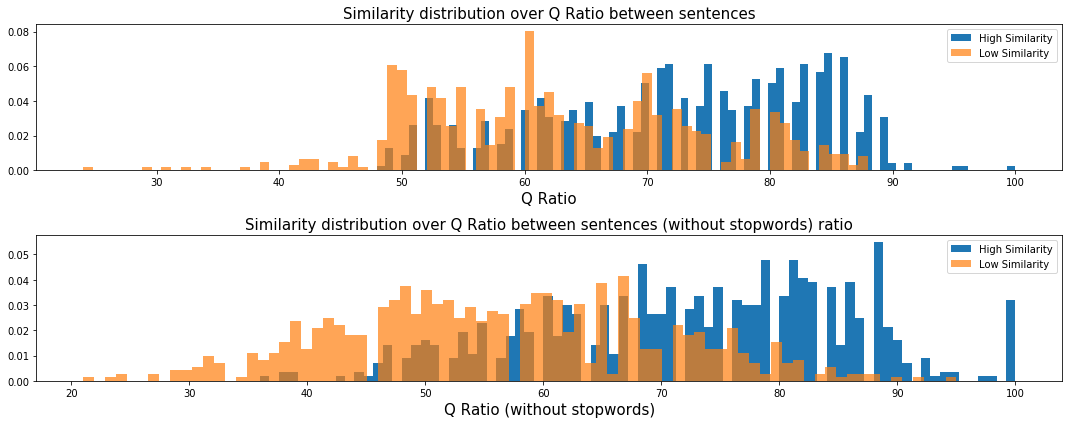

In [109]:
from fuzzywuzzy import fuzz

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
train_qratio = df_train.apply(lambda x: fuzz.QRatio(x["sent1"], x["sent2"]), axis=1)
plt.hist(train_qratio[df_train['similarity'] > 2.5], bins=80, normed=True, label='High Similarity')
plt.hist(train_qratio[df_train['similarity'] < 2.5], bins=80, normed=True, alpha=0.7, label='Low Similarity')
plt.legend()
plt.title('Similarity distribution over Q Ratio between sentences', fontsize=15)
plt.xlabel('Q Ratio', fontsize=15)


plt.subplot(2, 1, 2)
train_qratio_no_stopwords = df_train.apply(lambda x: fuzz.QRatio(" ".join([w for w in text_to_word_sequence(x["sent1"]) if w not in stopwords_eng]),
                                                                 " ".join([w for w in text_to_word_sequence(x["sent2"]) if w not in stopwords_eng])), axis=1)
plt.hist(train_qratio_no_stopwords[df_train['similarity'] > 2.5], bins=80, normed=True, label='High Similarity')
plt.hist(train_qratio_no_stopwords[df_train['similarity'] < 2.5], bins=80, normed=True, alpha=0.7, label='Low Similarity')
plt.legend()
plt.title('Similarity distribution over Q Ratio between sentences (without stopwords) ratio', fontsize=15)
plt.xlabel('Q Ratio (without stopwords)', fontsize=15)
plt.tight_layout()

###### 句子向量间的 cosine distance

如下图所示, (去掉停词的)相似句子向量间的 cosine distance 普遍偏小, 且分布相对集中; 而不相似句子向量间的 cosine distance 偏大, 且分布跨度很宽.

因此`句子向量间的 cosine distance`也是一个有效的特征.

In [116]:
def create_lookup_table(filename):

    from collections import defaultdict
    # load embedding into memory, skip first line
    with open(filename,'r') as file:
        lines = file.readlines()

    # create a map of words to vectors
    embedding = defaultdict(lambda: np.zeros((300,), dtype=np.float32))
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

lookup_table = create_lookup_table("simple.glove.840B.300d.txt")

def sent2vec(sent):
    words = [w for w in text_to_word_sequence(sent) if w not in stopwords_eng]
    # print(len(words))
    M = []
    for w in words:
        try:
            M.append(lookup_table[w])
        except:
            continue
    M = np.array(M)
    # print(M)
    
    v = M.sum(axis=0)
    # print(v)
    return v / np.sqrt((v ** 2).sum())

df_train["sv1"] = df_train.sent1.apply(sent2vec)
df_train["sv2"] = df_train.sent2.apply(sent2vec)

Text(0.5,0,'cosine distance (without stopwords)')

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


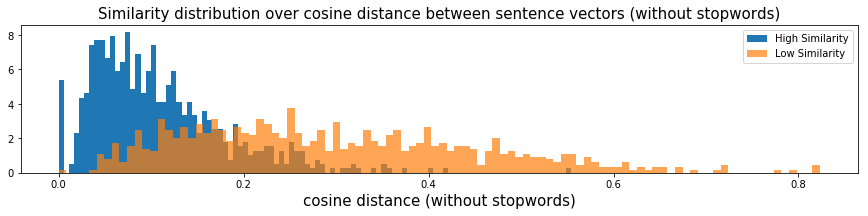

In [118]:
from scipy.spatial import distance

plt.figure(figsize=(15, 6))
train_consine = df_train.apply(lambda x: distance.cosine(x.sv1, x.sv2), axis=1)
plt.hist(train_consine[df_train['similarity'] > 2.5], bins=100, normed=True, label='High Similarity')
plt.hist(train_consine[df_train['similarity'] < 2.5], bins=100, normed=True, alpha=0.7, label='Low Similarity')
plt.legend()
plt.title('Similarity distribution over cosine distance between sentence vectors (without stopwords)', fontsize=15)
plt.xlabel('cosine distance (without stopwords)', fontsize=15)

### 2.3 WordNet-based similarity

在了解了本周的项目之后, 我们首先上网搜索了相关资料. 恰好 Coursera 上有一门讲 [Python Text Mining](https://www.coursera.org/learn/python-text-mining/home/info) 的课程, 并且在第四周的课上介绍了 Semantic Text Similarity（基于 WordNet）。

下图是基于 WordNet 计算 Semantic Text Similarity 的一个示例. 简单地说, WordNet 是一个英语词典, 它以树的形式将同义词组织起来. (就像`界门纲目科属种`的生物分类法).

其中一种度量单词相似性的方法称为`Path Similarity`, 距离的表示见下图.

![Path Similarity](path_similarity.jpg)

在本项目中, 我们采用了两种不需要句子之外的数据 (比如辅助字典) 的两种相似度度量方法, Path Similarity 和 Wup Similarity.

以此求句子相似性的思路如下:

1. 从句子中提取单词, 并且求每个单词的同义词集 (Synsets);
2. 然后对句子1 中的每个单词, 计算它的与句子2 中所有单词的 Path/Wup Similarity, 取其中的最大值, 对句子1 中所有求得的这样的最大值求均值作为句子1 对于句子2 的相似度;
3. 由于这是一个非对称的相似性, 因此再以同样方法求句子2 对于句子1 的相似度;
4. 以两个相似度的均值作为最终句子的相似度.

这样, 我们又得到 2 个特征:

* 基于 WordNet 的相似度特征 f4s:
    * Path Similarity;
    * Wup Similarity

同样地, 我们对`Path Similarity`的有效性进行调查.

可以看到, 相似句子间的 Path Similarity 普遍高于 0.5, 集中在 0.8; 而不相似句子的 Path Similarity 的分布较为分散, 集中在 0.6.

因此将 Path Similarity 作为特征是可行的.

In [119]:
import nltk
from nltk.corpus import wordnet as wn


def convert_tag(tag):
    """Convert the tag given by nltk.pos_tag to the tag used by wordnet.synsets"""
    
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        return None


def doc_to_synsets(doc):
    
    tokens = text_to_word_sequence(doc)  # tokenize
    
    token_pos = nltk.pos_tag(tokens)  # pos_tag
    
    synsets = []
    for tk, pos in token_pos:
        sn = wn.synsets(tk, convert_tag(pos))
        if sn:
            synsets.append(sn[0])
        
    return synsets


def similarity_score(s1, s2, mode="path_similarity"):

    scores = []
    for sn in s1:
        if mode == "path_similarity":
            tmp_scores = [sn.path_similarity(other) for other in s2 if sn.path_similarity(other)]
        if mode == "wup_similarity":
            tmp_scores = [sn.wup_similarity(other) for other in s2 if sn.wup_similarity(other)]
            
        if tmp_scores:
            scores.append(max(tmp_scores))
    return sum(scores) / len(scores)


def document_similarity(doc1, doc2):

    synsets1 = doc_to_synsets(doc1)
    synsets2 = doc_to_synsets(doc2)
    return (similarity_score(synsets1, synsets2, "path_similarity") + similarity_score(synsets2, synsets1, "path_similarity")) / 2, \
           (similarity_score(synsets1, synsets2, "wup_similarity") + similarity_score(synsets2, synsets1, "wup_similarity")) / 2
    
ds_train = np.array([document_similarity(s1, s2) for s1, s2 in zip(df_train.sent1, df_train.sent2)], dtype="float32")

Text(0.5,0,'path similarity between sentences')

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


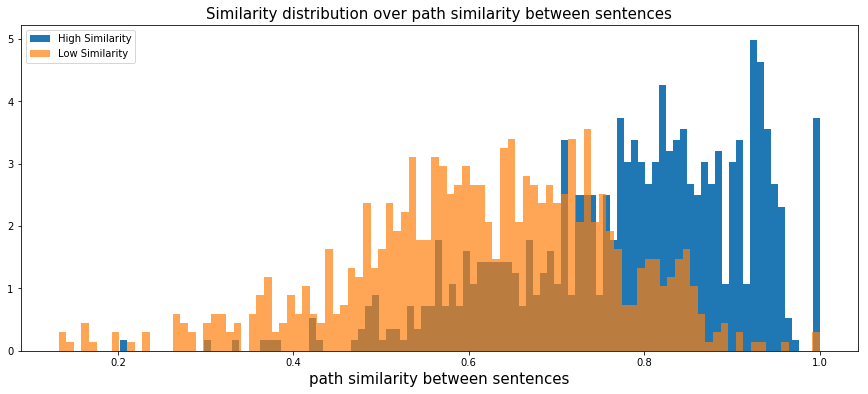

In [123]:
plt.figure(figsize=(15, 6))
plt.hist(ds_train[:, 0][df_train['similarity'] > 2.5], bins=100, normed=True, label='High Similarity')
plt.hist(ds_train[:, 0][df_train['similarity'] < 2.5], bins=100, normed=True, alpha=0.7, label='Low Similarity')
plt.legend()
plt.title('Similarity distribution over path similarity between sentences', fontsize=15)
plt.xlabel('path similarity between sentences', fontsize=15)

事实上, 增加了 Path Similarity 和 Wup Similarity 两个特征之后, 成绩提升了 0.01 (0.813395 -> 0.824451)

### 2.4 更多特征!

在看到**特征带来的红利**之后, 我们尝试获得更多特征, 增加了如下特征:

* gensim.doc2vec.docvecs.similarity f5s

* 基于 tf-idf 的距离特征 f6s:
    * cosine distance
    * manhattan distance
    * euclidean_distance
* 基于 lsa 向量的距离特征 f7s:
    * cosine distance
    * manhattan distance
    * jaccard distance
    * canberra distance
    * euclidean distance
    * minkowski distance
    * braycurtis distance
* 基于 lda 向量的距离特征 f8s (此类特征是有害或者无效的, 实际未使用, 此后不再讨论):
    * cosine distance
    * manhattan distance
    * jaccard distance
    * canberra distance
    * euclidean distance
    * minkowski distance
    * braycurtis distance
* 编辑距离相关的特征 f9s (此类特征也是有害的或无效的, 实际并未使用, 此后不再讨论):
    * levenshtein distance
    * jaro distance
    * jaro-winkler distance
    * ratio similarity

所有这些特征, 包括之前未加进来的 Word Mover Distance 以及 Normalized Word Mover Distance, 在单一 XGBRegressor 和 [Glove.840B.300d.txt](http://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip) 的情况下, 取得了 0.849993 的成绩!

而使用粗糙的 Ensemble 方法, 结合未经过参数选择的 SVR, RandomForestRegressor, GradientBoostingRegressor, LightGBMRegressor, XGBRegressor, 成绩达到了 0.851685!

由于我们使用了比较多的特征, 无法一一讨论它们与相似度的相关程度. 因此, 我们仅从`相关性`上去一探特征的有效性.

如下图所示, 最后一行是句子语义相似性与各特征的相关性. 我们需要与相似性强正相关或强负相关的特征, 而那些与相似性并不相关的, 在训练模型的过程中可以忽略.

可以看到, 上述的`共用单词比`, `Q Ratio`, `句子向量的 cosine distance`, `path similarity`都是与相似性具有强正/负相关性的. (事先并没有经过筛选, 很意外地, 它们都被选中了)

此外, 表示相似性的特征与句子语义相似性成正相关关系, 而表示距离的特征与句子语义相似性成负相关关系. 这符合基本逻辑: ***距离越远, 越不相似.***

(图中还展示了特征间的相关性, 当然这并不是我们研究的重点, 不再展开讨论)

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.stats as stats
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from gensim.models import KeyedVectors
from sklearn.metrics import pairwise

In [126]:
# 构建句子集, 方便后续操作
sentences = pd.concat([df_train.loc[:, "sent1"], df_train.loc[:, "sent2"],
                   df_test.loc[:, "sent1"], df_test.loc[:, "sent2"]]).tolist()

# TODO: 要不要去掉停词?
word_sequences = [text_to_word_sequence(s) for s in sentences]
tagged_sents = [TaggedDocument(ws, [str(i)]) for i, ws in enumerate(word_sequences)]  # 用于 docv2vec

doc2vec = Doc2Vec(tagged_sents, size=300, dm=0, alpha=0.25, min_alpha=1e-4, iter=30, workers=1, seed=609)

In [127]:
tfidfv = TfidfVectorizer(ngram_range=(1, 4), stop_words=stopwords_eng)

tfidf_matrix = tfidfv.fit_transform(sentences)

In [130]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=609)

lsa_matrix = svd.fit_transform(tfidf_matrix)

In [133]:
# 此处加载模型的目的仅仅是为了计算 word mover distance
keyedvectors = KeyedVectors.load_word2vec_format("simple.glove.840B.300d.h.txt")

def wmd(s1, s2):
    s1 = text_to_word_sequence(s1)
    s2 = text_to_word_sequence(s2)
    s1 = [w for w in s1 if w not in stopwords_eng]
    s2 = [w for w in s2 if w not in stopwords_eng]
    return keyedvectors.wmdistance(s1, s2)

In [136]:
norm_keyedvectors = KeyedVectors.load_word2vec_format("simple.glove.840B.300d.h.txt")
norm_keyedvectors.init_sims(replace=True)

def norm_wmd(s1, s2):
    s1 = text_to_word_sequence(s1)
    s2 = text_to_word_sequence(s2)
    s1 = [w for w in s1 if w not in stopwords_eng]
    s2 = [w for w in s2 if w not in stopwords_eng]
    return norm_keyedvectors.wmdistance(s1, s2)

In [140]:
train = pd.DataFrame()


train["len_s1"] = df_train.sent1.apply(lambda x: len(x))
train["len_s2"] = df_train.sent2.apply(lambda x: len(x))
train["diff_len"] = train.len_s1 - train.len_s2
train["len_char_s1"] = df_train.sent1.apply(lambda x: len("".join(set(x.replace(" ", "")))))
train["len_char_s2"] = df_train.sent2.apply(lambda x: len("".join(set(x.replace(" ", "")))))
train["len_word_s1"] = df_train.sent1.apply(lambda x: len(x.split()))
train["len_word_s2"] = df_train.sent2.apply(lambda x: len(x.split()))
train["common_words"] = df_train.apply(lambda x: len(set(x["sent1"].lower().split()).intersection(
set(x["sent2"].lower().split()))), axis=1)

# 帮助不大, 结果略微下降
# train["levenshtein"] = df_train.apply(lambda x: Levenshtein.distance(x.sent1, x.sent2), axis=1)
# # train["hamming"] = df_train.apply(lambda x: Levenshtein.hamming(x.sent1, x.sent2), axis=1)
# train["jaro"] = df_train.apply(lambda x: Levenshtein.jaro(x.sent1, x.sent2), axis=1)
# train["jaro_winkler"] = df_train.apply(lambda x: Levenshtein.jaro_winkler(x.sent1, x.sent2), axis=1)
# train["ratio"] = df_train.apply(lambda x: Levenshtein.ratio(x.sent1, x.sent2), axis=1)
# # train["seqratio"] = df_train.apply(lambda x: Levenshtein.ratio(word_sequences(x.sent1), word_sequences(x.sent2)), axis=1)

ds_train = np.array([document_similarity(s1, s2) for s1, s2 in zip(df_train.sent1, df_train.sent2)], dtype="float32")
train["path_similarity"] = ds_train[:, 0]
train["wup_similarity"] = ds_train[:, 1]


train["fuzz_qratio"] = df_train.apply(lambda x: fuzz.QRatio(x["sent1"], x["sent2"]), axis=1)
train["fuzz_wratio"] = df_train.apply(lambda x: fuzz.WRatio(x["sent1"], x["sent2"]), axis=1)
train["fuzz_partial_ratio"] = df_train.apply(lambda x: fuzz.partial_ratio(x["sent1"], x["sent2"]), axis=1)
train["fuzz_partial_token_set_ratio"] = df_train.apply(lambda x: fuzz.partial_token_set_ratio(x["sent1"], x["sent2"]), axis=1)
train["fuzz_partial_token_sort_ratio"] = df_train.apply(lambda x: fuzz.partial_token_sort_ratio(x["sent1"], x["sent2"]), axis=1)
train["fuzz_token_set_ratio"] = df_train.apply(lambda x: fuzz.token_set_ratio(x["sent1"], x["sent2"]), axis=1)
train["fuzz_token_sort_ratio"] = df_train.apply(lambda x: fuzz.token_sort_ratio(x["sent1"], x["sent2"]), axis=1)

train["sv1"] = df_train.sent1.apply(sent2vec)
train["sv2"] = df_train.sent2.apply(sent2vec)


train["wmd"] = df_train.apply(lambda x: wmd(x.sent1, x.sent2), axis=1)
train["norm_wmd"] = df_train.apply(lambda x: norm_wmd(x.sent1, x.sent2), axis=1)
train["cosine"] = train.apply(lambda x: distance.cosine(x.sv1, x.sv2), axis=1)
train["manhattan"] = train.apply(lambda x: distance.cityblock(x.sv1, x.sv2), axis=1)
train["jaccard"] = train.apply(lambda x: distance.jaccard(x.sv1, x.sv2), axis=1)
train["canberra"] = train.apply(lambda x: distance.canberra(x.sv1, x.sv2), axis=1)
train["euclidean"] = train.apply(lambda x: distance.euclidean(x.sv1, x.sv2), axis=1)
train["minkowski"] = train.apply(lambda x: distance.minkowski(x.sv1, x.sv2), axis=1)
train["braycurtis"] = train.apply(lambda x: distance.braycurtis(x.sv1, x.sv2), axis=1)
train["doc2vec_sim"] = np.array([doc2vec.docvecs.similarity(i1, i2) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["cosine_tfidf"] = np.array([pairwise.cosine_distances(tfidf_matrix[i1], tfidf_matrix[i2])[0][0] for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["manhattan_tfidf"] = np.array([pairwise.manhattan_distances(tfidf_matrix[i1], tfidf_matrix[i2])[0][0] for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["euclidean_tfidf"] = np.array([pairwise.euclidean_distances(tfidf_matrix[i1], tfidf_matrix[i2])[0][0] for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["cosine_lsa"] = np.array([distance.cosine(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["manhattan_lsa"] = np.array([distance.cityblock(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["jaccard_lsa"] = np.array([distance.jaccard(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["canberra_lsa"] = np.array([distance.canberra(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["euclidean_lsa"] = np.array([distance.euclidean(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["minkowski_lsa"] = np.array([distance.minkowski(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
train["braycurtis_lsa"] = np.array([distance.braycurtis(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")

# 基于 LDA 的特征反而是有害的
# train["cosine_lda"] = np.array([distance.cosine(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
# train["manhattan_lda"] = np.array([distance.cityblock(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
# train["jaccard_lda"] = np.array([distance.jaccard(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
# train["canberra_lda"] = np.array([distance.canberra(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
# train["euclidean_lda"] = np.array([distance.euclidean(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
# train["minkowski_lda"] = np.array([distance.minkowski(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")
# train["braycurtis_lda"] = np.array([distance.braycurtis(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(0, 1500), range(1500, 3000))], dtype="float32")

train["skew_s1"] = train.sv1.apply(stats.skew)
train["skew_s2"] = train.sv2.apply(stats.skew)
train["kurtosis_s1"] = train.sv1.apply(stats.kurtosis)
train["kurtosis_s2"] = train.sv2.apply(stats.kurtosis)

train["similarity"] = df_train["similarity"]

In [141]:
train_no_vec = train.drop(["sv1", "sv2"], axis=1)

In [162]:
correlations = train_no_vec.corr()

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


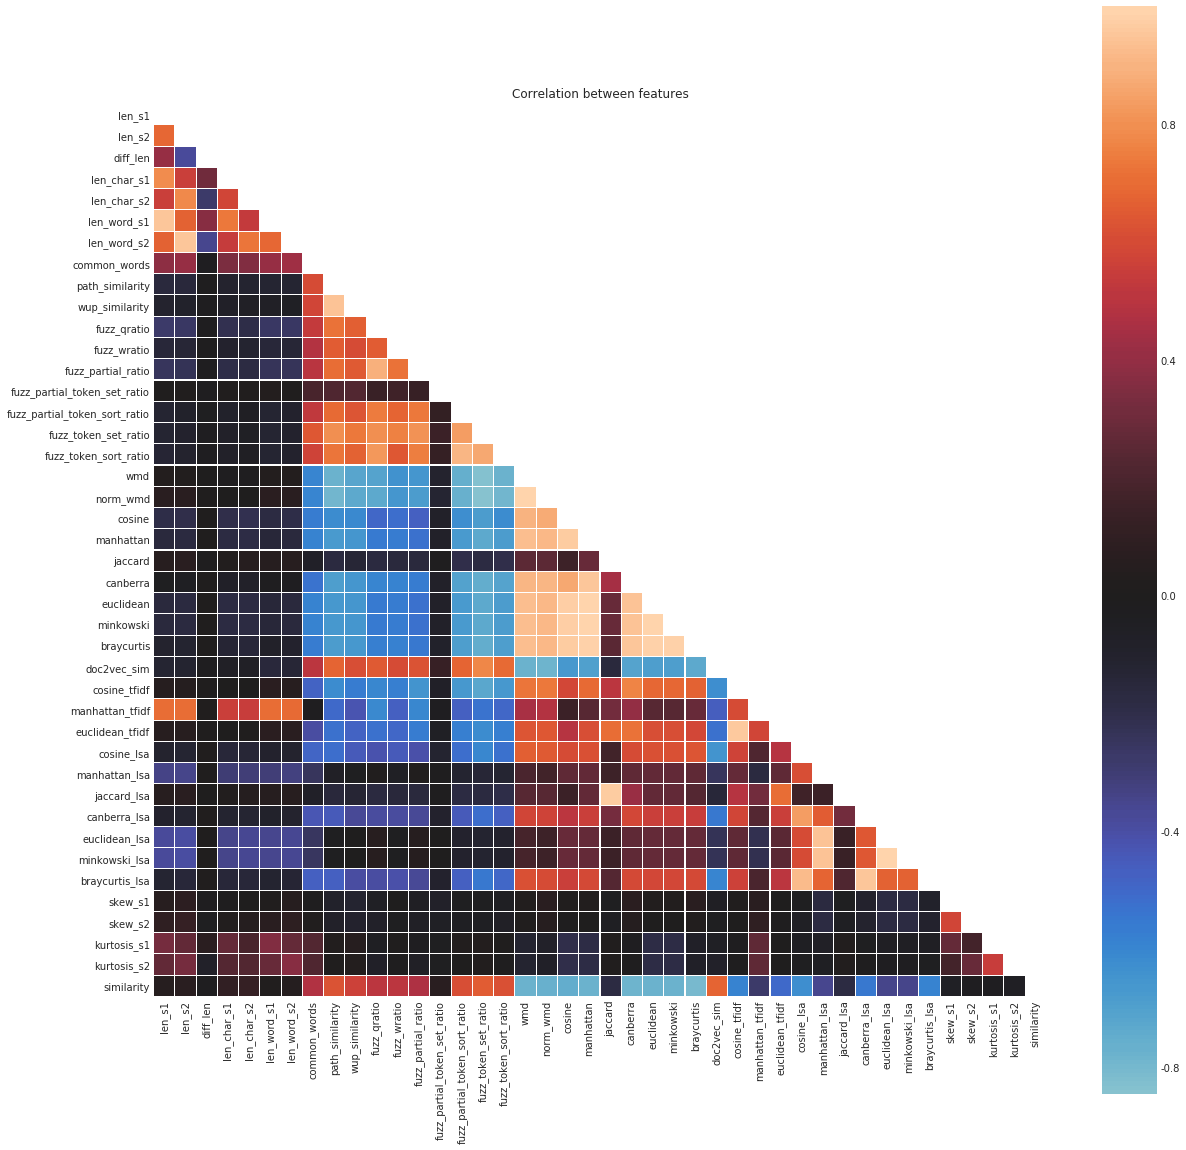

In [161]:
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (20, 20)


mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(correlations, mask=mask, square=True, linewidths=0.1, center=0.0)
plt.title("Correlation between features")
plt.show()

## 3. 评测结果展示

### 3.1 预测值的概率分布

上一节, 我们提出了一个先验假设, 即:

> 训练数据与测试数据独立同分布, 那么测试数据的相似性预测值总体也应该服从均匀分布

看看我们的预测结果是否如此. 与最终提交的项目保持一致, 此处同样使用了 ensemble 的方法. 得到的预测值分布如下图所示.

可以看到, 不相似的比例确实更大一些, 概率分布也挺像均匀分布的, 只是相似度在 3 到 4 之间的预测值似乎偏多了. 也许这正是我们的模型的不足之处吧, 没有拟合好这部分的数据.

In [165]:
test = pd.DataFrame()

test["len_s1"] = df_test.sent1.apply(lambda x: len(x))
test["len_s2"] = df_test.sent2.apply(lambda x: len(x))
test["diff_len"] = test.len_s1 - test.len_s2
test["len_char_s1"] = df_test.sent1.apply(lambda x: len("".join(set(x.replace(" ", "")))))
test["len_char_s2"] = df_test.sent2.apply(lambda x: len("".join(set(x.replace(" ", "")))))
test["len_word_s1"] = df_test.sent1.apply(lambda x: len(x.split()))
test["len_word_s2"] = df_test.sent2.apply(lambda x: len(x.split()))
test["common_words"] = df_test.apply(lambda x: len(set(x["sent1"].lower().split()).intersection(
set(x["sent2"].lower().split()))), axis=1)


# 帮助不大, 结果略微下降
# test["levenshtein"] = df_test.apply(lambda x: Levenshtein.distance(x.sent1, x.sent2), axis=1)
# # test["hamming"] = df_test.apply(lambda x: Levenshtein.hamming(x.sent1, x.sent2), axis=1)
# test["jaro"] = df_test.apply(lambda x: Levenshtein.jaro(x.sent1, x.sent2), axis=1)
# test["jaro_winkler"] = df_test.apply(lambda x: Levenshtein.jaro_winkler(x.sent1, x.sent2), axis=1)
# test["ratio"] = df_test.apply(lambda x: Levenshtein.ratio(x.sent1, x.sent2), axis=1)
# # test["seqratio"] = df_test.apply(lambda x: Levenshtein.ratio(word_sequences(x.sent1), word_sequences(x.sent2)), axis=1)

ds_test = np.array([document_similarity(s1, s2) for s1, s2 in zip(df_test.sent1, df_test.sent2)], dtype="float32")
test["path_similarity"] = ds_test[:, 0]
test["wup_similarity"] = ds_test[:, 1]


test["fuzz_qratio"] = df_test.apply(lambda x: fuzz.QRatio(x["sent1"], x["sent2"]), axis=1)
test["fuzz_wratio"] = df_test.apply(lambda x: fuzz.WRatio(x["sent1"], x["sent2"]), axis=1)
test["fuzz_partial_ratio"] = df_test.apply(lambda x: fuzz.partial_ratio(x["sent1"], x["sent2"]), axis=1)
test["fuzz_partial_token_set_ratio"] = df_test.apply(lambda x: fuzz.partial_token_set_ratio(x["sent1"], x["sent2"]), axis=1)
test["fuzz_partial_token_sort_ratio"] = df_test.apply(lambda x: fuzz.partial_token_sort_ratio(x["sent1"], x["sent2"]), axis=1)
test["fuzz_token_set_ratio"] = df_test.apply(lambda x: fuzz.token_set_ratio(x["sent1"], x["sent2"]), axis=1)
test["fuzz_token_sort_ratio"] = df_test.apply(lambda x: fuzz.token_sort_ratio(x["sent1"], x["sent2"]), axis=1)

test["sv1"] = df_test.sent1.apply(sent2vec)
test["sv2"] = df_test.sent2.apply(sent2vec)

test["wmd"] = df_test.apply(lambda x: wmd(x.sent1, x.sent2), axis=1)
test["norm_wmd"] = df_test.apply(lambda x: norm_wmd(x.sent1, x.sent2), axis=1)
test["cosine"] = test.apply(lambda x: distance.cosine(x.sv1, x.sv2), axis=1)
test["manhattan"] = test.apply(lambda x: distance.cityblock(x.sv1, x.sv2), axis=1)
test["jaccard"] = test.apply(lambda x: distance.jaccard(x.sv1, x.sv2), axis=1)
test["canberra"] = test.apply(lambda x: distance.canberra(x.sv1, x.sv2), axis=1)
test["euclidean"] = test.apply(lambda x: distance.euclidean(x.sv1, x.sv2), axis=1)
test["minkowski"] = test.apply(lambda x: distance.minkowski(x.sv1, x.sv2), axis=1)
test["braycurtis"] = test.apply(lambda x: distance.braycurtis(x.sv1, x.sv2), axis=1)
test["doc2vec_sim"] = np.array([doc2vec.docvecs.similarity(i1, i2) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["cosine_tfidf"] = np.array([pairwise.cosine_distances(tfidf_matrix[i1], tfidf_matrix[i2])[0][0] for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["manhattan_tfidf"] = np.array([pairwise.manhattan_distances(tfidf_matrix[i1], tfidf_matrix[i2])[0][0] for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["euclidean_tfidf"] = np.array([pairwise.euclidean_distances(tfidf_matrix[i1], tfidf_matrix[i2])[0][0] for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["cosine_lsa"] = np.array([distance.cosine(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["manhattan_lsa"] = np.array([distance.cityblock(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["jaccard_lsa"] = np.array([distance.jaccard(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["canberra_lsa"] = np.array([distance.canberra(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["euclidean_lsa"] = np.array([distance.euclidean(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["minkowski_lsa"] = np.array([distance.minkowski(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
test["braycurtis_lsa"] = np.array([distance.braycurtis(lsa_matrix[i1], lsa_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")

# 基于 LDA 的特征反而是有害的
# test["cosine_lda"] = np.array([distance.cosine(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
# test["manhattan_lda"] = np.array([distance.cityblock(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
# test["jaccard_lda"] = np.array([distance.jaccard(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
# test["canberra_lda"] = np.array([distance.canberra(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
# test["euclidean_lda"] = np.array([distance.euclidean(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
# test["minkowski_lda"] = np.array([distance.minkowski(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")
# test["braycurtis_lda"] = np.array([distance.braycurtis(lda_matrix[i1], lda_matrix[i2]) for i1, i2 in zip(range(3000, 3750), range(3750, 4500))], dtype="float32")


test["skew_s1"] = test.sv1.apply(stats.skew)
test["skew_s2"] = test.sv2.apply(stats.skew)
test["kurtosis_s1"] = test.sv1.apply(stats.kurtosis)
test["kurtosis_s2"] = test.sv2.apply(stats.kurtosis)

In [175]:
train_no_vec = train.drop(["sv1", "sv2", "similarity"], axis=1)  # 不使用向量作为输入，因此去掉
test_no_vec = test.drop(["sv1", "sv2"], axis=1)

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

train_std = std.fit_transform(train_no_vec)
test_std = std.transform(test_no_vec)

x_train, x_valid, y_train, y_valid = train_test_split(train_std, df_train["similarity"], test_size=0.1, random_state=609)

In [194]:
import xgboost as xgb

xgbr_params = {
    "objective": "reg:linear",
    "learning_rate": 0.05,  # 0.01 ~ 0.2
    "max_depth": 4,  # 3 ~ 10; 4 may be the best
    "seed": 609,
    "n_estimators": 500
}

xgbr_train = xgb.DMatrix(x_train, label=y_train)
xgbr_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(xgbr_train, "train"), (xgbr_valid, "valid")]

xgbr = xgb.XGBRegressor(**xgbr_params)
xgbr.fit(x_train, y_train, early_stopping_rounds=50, eval_metric="rmse", eval_set=[(x_valid, y_valid)], verbose=10)
xgbr_pred = xgbr.predict(test_std)

[0]	validation_0-rmse:2.25134
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.52096
[20]	validation_0-rmse:1.15385
[30]	validation_0-rmse:0.971419
[40]	validation_0-rmse:0.890739
[50]	validation_0-rmse:0.854271
[60]	validation_0-rmse:0.83151
[70]	validation_0-rmse:0.821287
[80]	validation_0-rmse:0.816247
[90]	validation_0-rmse:0.8139
[100]	validation_0-rmse:0.81403
[110]	validation_0-rmse:0.812861
[120]	validation_0-rmse:0.811079
[130]	validation_0-rmse:0.809824
[140]	validation_0-rmse:0.808085
[150]	validation_0-rmse:0.807924
[160]	validation_0-rmse:0.807555
[170]	validation_0-rmse:0.80671
[180]	validation_0-rmse:0.806181
[190]	validation_0-rmse:0.807512
[200]	validation_0-rmse:0.806758
[210]	validation_0-rmse:0.807444
[220]	validation_0-rmse:0.807736
Stopping. Best iteration:
[179]	validation_0-rmse:0.805859



In [201]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb


svr = SVR("rbf", C=1.0, gamma=0.01)

svr.fit(train_std, df_train["similarity"])
svr_pred = svr.predict(test_std)

In [202]:
rfr = RandomForestRegressor(max_depth=10, n_estimators=35)

rfr.fit(train_std, df_train["similarity"])
rfr_pred = rfr.predict(test_std)

In [203]:
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, n_estimators=50)

gbr.fit(train_std, df_train["similarity"])
gbr_pred = gbr.predict(test_std)

In [204]:
lgbr_params = {
    "objective": "regression",
    "learning_rate": 0.05,
    "num_iteration": 1000,
    "boosting_type": "gbdt",
    "num_leaves": 5,
    "max_bin": 30,
    "bagging_fraction": 1,
    "feature_fraction": 0.7,
    "bagging_seed": 9,
    "feature_fraction_seed": 9,
    "min_data_in_leaf": 16,
    "metric": "root_mean_squared_error",
}

lgbr = lgb.LGBMRegressor(**lgbr_params)

lgbr.fit(x_train, y_train, early_stopping_rounds=100, eval_set=[(x_valid, y_valid)], verbose=10)
lgbr_pred = lgbr.predict(test_std)

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


Training until validation scores don't improve for 100 rounds.
[10]	valid_0's l2: 1.57614
[20]	valid_0's l2: 1.12403
[30]	valid_0's l2: 0.928739
[40]	valid_0's l2: 0.836837
[50]	valid_0's l2: 0.798365
[60]	valid_0's l2: 0.77071
[70]	valid_0's l2: 0.751936
[80]	valid_0's l2: 0.737031
[90]	valid_0's l2: 0.728896
[100]	valid_0's l2: 0.721442
[110]	valid_0's l2: 0.712161
[120]	valid_0's l2: 0.712133
[130]	valid_0's l2: 0.702118
[140]	valid_0's l2: 0.700333
[150]	valid_0's l2: 0.697805
[160]	valid_0's l2: 0.697921
[170]	valid_0's l2: 0.696177
[180]	valid_0's l2: 0.691245
[190]	valid_0's l2: 0.689161
[200]	valid_0's l2: 0.686753
[210]	valid_0's l2: 0.685318
[220]	valid_0's l2: 0.683012
[230]	valid_0's l2: 0.682542
[240]	valid_0's l2: 0.681434
[250]	valid_0's l2: 0.681806
[260]	valid_0's l2: 0.679648
[270]	valid_0's l2: 0.679851
[280]	valid_0's l2: 0.678094
[290]	valid_0's l2: 0.678727
[300]	valid_0's l2: 0.678198
[310]	valid_0's l2: 0.678463
[320]	valid_0's l2: 0.681829
[330]	valid_0's l2: 0

In [208]:
preds = np.zeros(750)

for idx, p, s, r, g, l in zip(range(750), xgbr_pred, svr_pred, rfr_pred, gbr_pred, lgbr_pred):
    if p > 5:
        p = 5.0
    elif p < 0:
        p = 0
    if s > 5:
        s = 5.0
    elif s < 0:
        s = 0
    if r > 5:
        r = 5.0
    elif r < 0:
        r = 0
    if g > 5:
        g = 5.0
    elif g < 0:
        g = 0
    if l > 5:
        l = 5.0
    elif l < 0:
        l = 0        
    preds[idx] = sum([p, s,r, g, l]) / 5.0

/home/kissg/.pyenv/versions/3.5.2/envs/tailcamp/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['WenQuanYi Micro Hei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


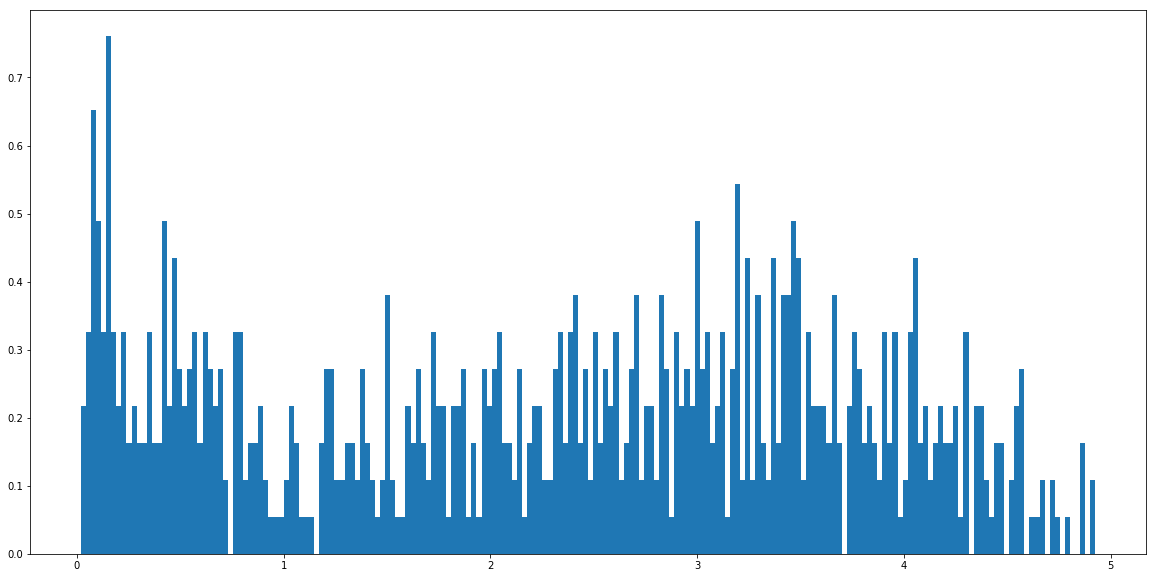

In [214]:
plt.figure(figsize=(20,10)) 
plt.hist(preds, bins=200, normed=True)
plt.show()

### 3.2 更多特征与更好模型带来的性能提升

本项目, 我们在特征提取上投入了更多的关注度, 而模型只是从 XGBRegressor 提升到了 SVR, RandomForestRegressor, GradientBoostingRegressor, LightGBMRegressor, XGBRegressor 的 Ensemble. (说是　Ensemble 其实也不太对, 我们只是对各 Regressors 的结果求了平均. 姑且称为 Ensemble 吧)

我们记录了使用不同特征与模型的成绩, 不妨看一下它们带来的性能提升.

> f[n]s 表示的特征见上文各特征出处.

| 模型 | 预训练的词向量 | 特征 | 成绩 | 注释 | 
| :-: | :-: | :-: | :-: | :-: |
| XGBRegressor | Glove 100d | f1s + f2s + f3s | 0.773975 | 不含 Word Mover Distance|
| XGBRegressor | Word2Vec 300d |f1s + f2s + f3s | 0.797716 | 不含 Word Mover Distance|
| XGBRegressor | Fasttext 300d |f1s + f2s + f3s | 0.811882 | 不含 Word Mover Distance|
| XGBRegressor | Glove 300d |f1s + f2s + f3s + f4s | 0.824451 | 不含 Word Mover Distance|
| 粗糙的 Ensemble | Glove 300d |f1s + f2s + f3s + f4s| 0.842447 | - |
| XGBRegressor | Glove 300d |f1s + f2s + f3s + f4s + f5s + f6s | 0.845027 | - |
| 粗糙的 Ensemble | Glove 300d |f1s + f2s + f3s + f4s + f5s + f6s | 0.851685 | - | 
| XGBRegressor | Glove 300d |f1s + f2s + f3s + f4s + f5s + f6s + f7s| 0.849993 | - |
| 微调的 Ensemble | Glove 300d |f1s + f2s + f3s + f4s + f5s + f6s + f7s| 0.855244 | - |
| PS: 在第二部分的末尾, 我们已经证明了部分特征实际是无效的 | | | | |

从结果来看, 更多特征带来的性能提升更明显. 但在我们的实践中, f8s 和 f9s 并不能再带来性能的提升, 反而使性能略微下降了.

Ensemble 带来的性能提升有限, 我们认为有 3 方面原因:

1. 使用方法不对, 或者各 Regressor 并调至最优参数状态;
2. XGBRegressor 太强了;
3. 太迟引入 Ensemble, 此时即使增加更多特征, 带来的性能提升也开始下降, 因此并不能归因于 Ensemble 不好.